# Part 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('dataset_Facebook.csv', delimiter=';')

#### 1. What is the most common type of post?

Photos are the most common type of post in the dataset.

In [3]:
df.groupby('Type').count().sort_values(by = 'Page total likes', ascending = False)['Page total likes']

Type
Photo     426
Status     45
Link       22
Video       7
Name: Page total likes, dtype: int64

#### 2.	On average, which type of post received most ‘Page total likes’? Does this agree with the post ‘like’ metric?

The Page total likes measure records the number of likes the page has when a post is published. Therefore to find the impact a post has made on the total page likes the difference between likes when the post is made and the next post can be used.

In [4]:
df_type = df[['Page total likes', 'Type']]

#Shift cells by 1 row so the page likes can be subtracted from the number of likes at the next post
df_type_shift = df[['Page total likes']].shift(1)
df_type_shift.rename(columns={'Page total likes':'Page total likes next post'}, inplace=True)

#As the next number of total page likes is unknown the last post in December
#will have to be assumed to have not increased the number of likes
df_type_shift.iloc[0,:]  = [139441] 

#Join the 2 dataframes into one and find the difference in likes
df_comb = pd.concat([df_type, df_type_shift],axis=1)
df_comb['Page Likes Diff'] = df_comb['Page total likes next post'] - df_comb['Page total likes']

#Groupby the Type to calculate the average increase in Likes from a particular type of post
df_comb.groupby('Type').mean().sort_values(by = 'Page Likes Diff', ascending = False).reset_index()[['Type', 'Page Likes Diff']]

,Type,Page Likes Diff
0,Link,139.181818
1,Photo,126.610329
2,Status,23.844444
3,Video,0.000000


Links on average receive the most 'Page total likes'.

In [5]:
df.groupby('Type').mean().sort_values(by = 'Page total likes', ascending = False).reset_index()[['Type', 'like']]

,Type,like
0,Video,231.428571
1,Status,176.711111
2,Photo,182.611765
3,Link,73.318182


Videos on average gain the most likes from a post which is very different to the page likes where they didn't increase the number of total page likes at all (based on the criteria chosen for relating posts to total page likes).

#### 3.	On average, do paid video posts (Paid=1) receive more shares than the unpaid ones? Given that this data is for a Facebook page of a cosmetics brand, can you think of any reasons for the results you obtain? (i.e. if no, then why not?)

In [6]:
df[df['Type']=='Video'].groupby('Paid').mean()['share']

Paid
0.0    59.333333
1.0    46.750000
Name: share, dtype: float64

In [7]:
df[df['Type']=='Video'][['Paid', 'share']]

,Paid,share
29,1.0,13.0
55,1.0,14.0
71,1.0,84.0
74,0.0,13.0
183,0.0,121.0
243,1.0,76.0
277,0.0,44.0


It seems that the paid video posts have less shares on average than the unpaid posts. However it must be noted that only 7 video posts are contained in the data (3 unpaid and 4 paid) which means the average can be influenced greatly by even 1 of the posts. From the table above it can be seen that an unpaid video received 121 shares whereas the other 2 received 13 and 44. Removing this 121 would drop the average to approxiately 29 shares. 

One reason that springs to mind for why an unpaid ad could achieve a high number of shares is that the post could have been a give away for cosmetic products and you would be entered into the draw if you shared the post. 

#### 4. 'Lifetime post consumers’ is the number of people who clicked anywhere in a post. ‘Lifetime post consumption’ is the number of clicks anywhere in a post. For each post, approximate the ‘consumption per user’ and determine the post type and month that, on average, receive the most ‘consumptions per user’. Is this result different from the total ‘Lifetime post consumers’ by post type and month?

In [8]:
#Consumptions per user calculation
df['Consumptions Per User'] = df['Lifetime Post Consumptions']/df['Lifetime Post Consumers']

Top 10 Types/Months combinations by average consumptions per user

In [9]:
df.groupby(['Type', 'Post Month']).mean().sort_values(by = 'Consumptions Per User', 
                                                      ascending = False)['Consumptions Per User'][:10].reset_index()

,Type,Post Month,Consumptions Per User
0,Photo,3,3.771165
1,Status,4,2.567589
2,Photo,6,2.321690
3,Status,5,1.938383
4,Video,7,1.917059
5,Photo,7,1.862242
6,Status,6,1.824124
7,Photo,10,1.806566
8,Photo,11,1.776056
9,Video,9,1.663088


Top 10 Types/Months combinations by total 'Lifetime post consumers'

In [10]:
df.groupby(['Type', 'Post Month']).sum().sort_values(by = 'Lifetime Post Consumers', 
                                                      ascending = False)['Lifetime Post Consumers'][:10].reset_index()

,Type,Post Month,Lifetime Post Consumers
0,Photo,6,37750
1,Photo,2,35270
2,Photo,4,33917
3,Photo,7,33244
4,Photo,3,32463
5,Status,12,25077
6,Photo,1,22861
7,Photo,10,22517
8,Photo,5,21444
9,Status,10,19897


The result for average consumptions per user (Photo & Month 3) differs from the total lifetime post consumers (Photo & Month 6) although it can be seen that the top 10 entries in the 2 tables share 5 Type/Month combinations

#### 5.	For the ‘Photo’ type posts, find the month that shows the greatest absolute skew in the distribution of the ‘consumptions per user’. Use whichever definition of ‘skew’ you think is appropriate for this data (e.g. it can be any numeric or visual estimate).

Using the definition of skewness contained in the scipy package in Python, a skewness value can be generated for each Month. The month with the largest skewness value would therefore show the greatest absolute skew that was asked for in the question. However because the data set is not large and the distributions for each Month are quite small, skewness can be heavily affected even by 1 point far from the rest of the values. Therefore the Kurtosis values will be able to indicate if that is indeed happening. The removal of a single point causing the skew can actually lead to the rest of the data falling within acceptable skewness levels which would question whether that distribution was displaying the 'greatest absolute skew'.

In [11]:
from scipy.stats import skew, kurtosis

#calculate skew
df_skew = df[df['Type']=='Photo'].groupby(['Type', 'Post Month'])['Consumptions Per User'].apply(lambda x: skew(x)).reset_index()

#calculate kurtosis
df_kurt = df[df['Type']=='Photo'].groupby(['Type', 'Post Month'])['Consumptions Per User'].apply(lambda x: kurtosis(x)).reset_index()

#Merge the 2 dataframes into 1 and rename columns
df_comb = df_skew.merge(df_kurt, on = ['Type', 'Post Month'])
df_comb.rename(columns={'Consumptions Per User_x':'Skewness', 'Consumptions Per User_y':'Kurtosis'}, inplace=True)

#display values from largest to smallest
df_comb.sort_values(by='Skewness', ascending=False)

,Type,Post Month,Skewness,Kurtosis
6,Photo,7,6.366617,38.703090
11,Photo,12,4.931417,23.530236
10,Photo,11,4.765291,23.670529
5,Photo,6,4.457133,17.930302
9,Photo,10,3.466137,12.263642
0,Photo,1,1.340527,1.688848
1,Photo,2,1.302729,2.150540
7,Photo,8,1.295538,1.638437
3,Photo,4,1.277036,1.467737
2,Photo,3,0.887827,-0.493436


The top 5 months have large skewness values. Photo posts in Month 7 shows the greatest skewness however the kurtosis value is very high. A box plot will be able to show how these points affecting skewness compare to the rest of the data

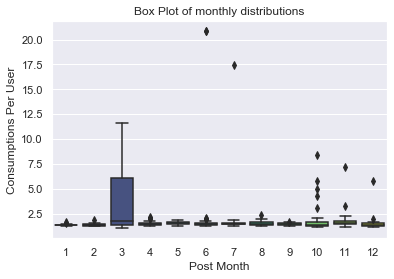

In [12]:
plt.title('Box Plot of monthly distributions')
sns.boxplot(x='Post Month',y='Consumptions Per User',data=df[df['Type']=='Photo'],palette='viridis')

As expected the skewness for Month 7 along with 6, 11 and 12 are being caused by 1 or 2 extreme points. However month 10 has more points affecting the skewness and appears to have the greatest skew based on the tail actually being longer than those by 1 point. The distributions of Months 7 and 10 will be plotted to raise this point.

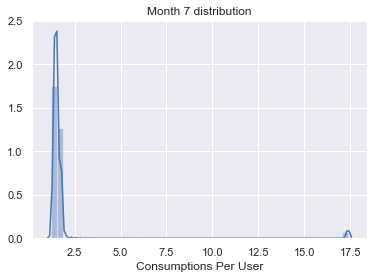

In [13]:
plt.title('Month 7 distribution')
sns.distplot(df[(df['Post Month']==7) & (df['Type']=='Photo')]['Consumptions Per User'])

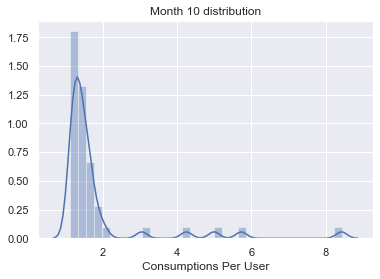

In [14]:
plt.title('Month 10 distribution')
sns.distplot(df[(df['Post Month']==10) & (df['Type']=='Photo')]['Consumptions Per User'])

In terms of a skewness equation Month 7 displays the greatest skewness but by plotting the data it seems Month 10 has the longest tail of the highly skewed months and what I would class as a greater case of skewness.

# Part 2

In [15]:
from scipy import stats
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
df = pd.read_csv('dataset_Facebook.csv', delimiter=';')

#Only select the measures outlines in the document
df = df[['Category', 'Type', 'Page total likes', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid', 'Lifetime Post Consumers']]

In order to predict lifetime post consumers, 3 models will be chosen to model the data (linear regression and regression with ridge and lasso regularisation). To use linear regression a series of assumption are required:

- Linear relationship
- Multivariate normality
- No or little multicollinearity
- No auto-correlation
- Homoscedasticity

### Target Variable (Lifetime Post Consumers)

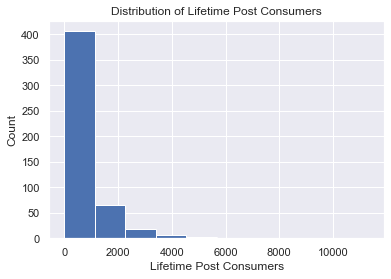

In [17]:
#Plot the distribution of the target variable
plt.title('Distribution of Lifetime Post Consumers')
plt.xlabel('Lifetime Post Consumers')
plt.ylabel('Count')
plt.hist(df['Lifetime Post Consumers']);

It appears the target variable for this model is positively skewed. To meet the multivariate normality assumption the target will be transformed to display a more normal distribution.

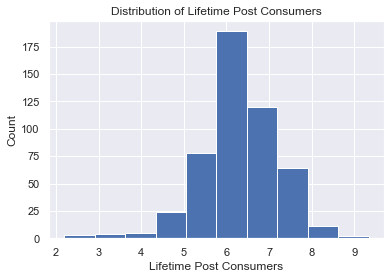

In [18]:
#Log transformation of target
df['Lifetime Post Consumers'] = np.log(df['Lifetime Post Consumers'])

#Plot the distribution of the target variable
plt.title('Distribution of Lifetime Post Consumers')
plt.xlabel('Lifetime Post Consumers')
plt.ylabel('Count')
plt.hist(df['Lifetime Post Consumers']);

### Removing outliers

A simple approach for now is defining outliers as anything 3 standard deviations away from the mean.

In [19]:
z = np.abs(stats.zscore(df['Lifetime Post Consumers']))

#rows to drop
rem = np.array(np.where(z > 3))[0]

print('Number of records removed: ', len(rem))

#dataframe with dropped rows
df = df[~df.index.isin(rem)]

Number of records removed:  6


A qq plot is able to assess for normality and with the removed records it shows an almost straight line indicating an approximation of normality.

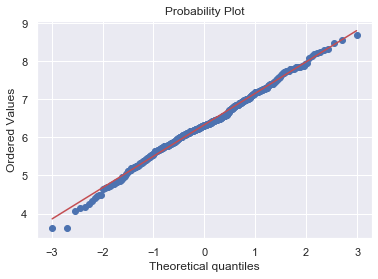

In [20]:
stats.probplot(df['Lifetime Post Consumers'], dist="norm", plot=plt);

### Missing Values Check

In [21]:
pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])

,Missing Values
Category,0
Type,0
Page total likes,0
Post Month,0
Post Weekday,0
Post Hour,0
Paid,1
Lifetime Post Consumers,0


One value is missing with the paid measure

In [22]:
df[df.isnull().any(axis=1)]

,Category,Type,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Consumers
499,2,Photo,81370,1,4,4,NaN,6.261492


In [23]:
df[(df['Type']=='Photo') & (df['Post Month']==1)].groupby(['Type', 'Post Month', 'Post Weekday']).mean().reset_index()

,Type,Post Month,Post Weekday,Category,Page total likes,Post Hour,Paid,Lifetime Post Consumers
0,Photo,1,1,3.000000,85683.666667,5.333333,0.00,6.918810
1,Photo,1,2,3.000000,86491.000000,7.000000,0.00,6.930495
2,Photo,1,3,2.500000,86491.000000,6.500000,0.00,7.456614
3,Photo,1,4,2.333333,83216.333333,8.666667,0.00,6.671173
4,Photo,1,5,2.250000,84139.500000,6.750000,0.00,6.641160
5,Photo,1,6,2.500000,86444.000000,10.000000,0.75,7.098723
6,Photo,1,7,3.000000,85536.000000,6.000000,0.00,6.795449


There is 1 missing value in the paid column. This can either be removed or deleted. As there's very little paid activity for photo posts in that month I will make the assumption that paid = 0.

In [24]:
df['Paid'].fillna(0, inplace=True)

### Predictor Variables

#### Type

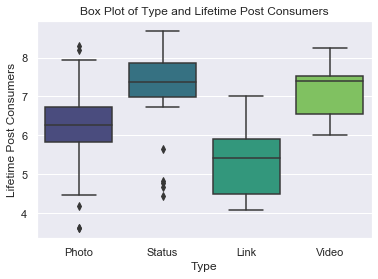

In [25]:
plt.title('Box Plot of Type and Lifetime Post Consumers')
sns.boxplot(x='Type',y='Lifetime Post Consumers',data=df,palette='viridis');

The status and video types show a higher lifetime post consumer than the other 2.

#### Post Month

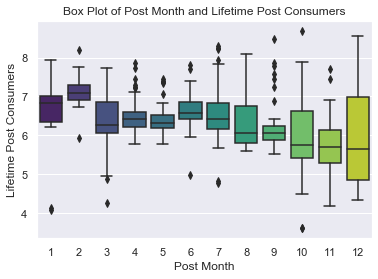

In [26]:
plt.title('Box Plot of Post Month and Lifetime Post Consumers')
sns.boxplot(x='Post Month',y='Lifetime Post Consumers',data=df,palette='viridis');

The post month seems to suggest that earlier in the year receives a higher lifetime post consumers than later on in the year althoug this is only based on 1 year of data so it is unknown if it's a trend or is caused by other factors. This isn't a concern for building and testing the model on this fixed set of data but it would be if moving forward with the model. This is something I would look into and also engineer features to account for change in effects between months.

#### Post Weekday

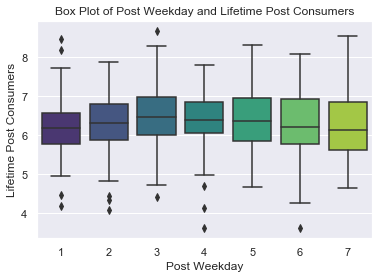

In [27]:
plt.title('Box Plot of Post Weekday and Lifetime Post Consumers')
sns.boxplot(x='Post Weekday',y='Lifetime Post Consumers',data=df,palette='viridis');

There are slight variations in the lifetime post consumers depending on the day of week a post is made.

#### Category

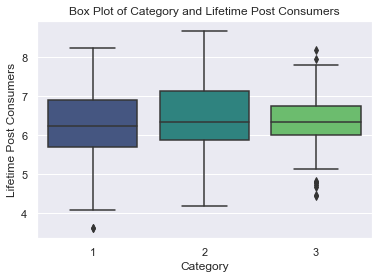

In [28]:
plt.title('Box Plot of Category and Lifetime Post Consumers')
sns.boxplot(x='Category',y='Lifetime Post Consumers',data=df,palette='viridis');

There are slight changed in lifetime post consumers depending on the category although not as drastic as type for example.

#### Page Total Likes

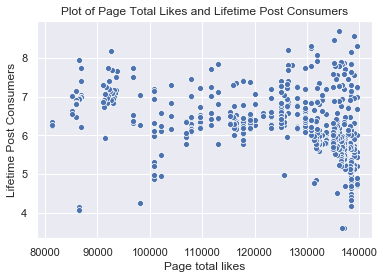

In [29]:
plt.title('Plot of Page Total Likes and Lifetime Post Consumers')
sns.scatterplot(x='Page total likes',y='Lifetime Post Consumers',data=df,palette='viridis');

The total page likes and lifetime post consumers don't appear to display any obvious trends.

#### Post Hour

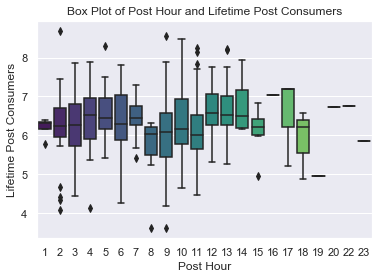

In [30]:
plt.title('Box Plot of Post Hour and Lifetime Post Consumers')
sns.boxplot(x='Post Hour',y='Lifetime Post Consumers',data=df,palette='viridis');

The time of day a post is made does have an impact on the lifetime post consumers.

#### Paid

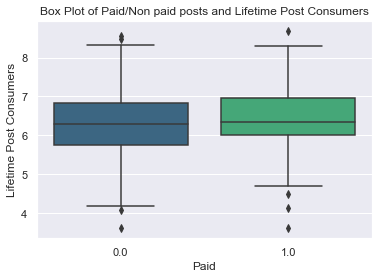

In [31]:
plt.title('Box Plot of Paid/Non paid posts and Lifetime Post Consumers')
sns.boxplot(x='Paid',y='Lifetime Post Consumers',data=df,palette='viridis');

Paid marketing seems to have a greater impact on lifetime post consumers than unpaid.

### Feature Engineering

Adding the number of likes to the company's page since the last post

In [32]:
#resetting index to account for removed rows due to outliers
df = df.reset_index(drop=True)

#Shift to get the difference in page likes between posts
df['Likes Since Last Post'] = df['Page total likes'] - df['Page total likes'].shift(-1)
df['Likes Since Last Post'].fillna(0, inplace=True)

#Create variable for if post was at the weekend. If 0 it will be a weekday so only 1 new feature is needed.
df['Weekend'] = df['Post Weekday'].apply(lambda x: 1 if ((x==6) | (x==7)) else 0)

#Create variable to understand if one post was made on a particular day or multiple posts. Works by looping 
#through data and checking if row above or below do not equal the same day. If they don't it will assign 1 else
#will just remain 0 for multiple posts.
df['Single Post'] = 0

for i in range(0,len(df)-1,1):
    if ((df.iloc[i,4] != df.iloc[(i-1),4]) & (df.iloc[i,4] != df.iloc[(i+1),4])):
        df.loc[i,'Single Post'] = 1
    else:
        0

#### Likes since last post

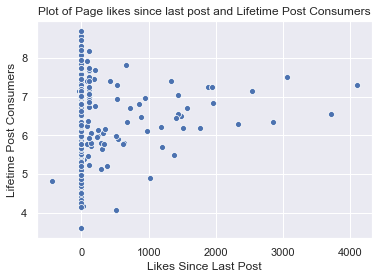

In [33]:
plt.title('Plot of Page likes since last post and Lifetime Post Consumers')
sns.scatterplot(x='Likes Since Last Post',y='Lifetime Post Consumers',data=df,palette='viridis');

There's possibly some slight trend in the number of page likes since last post and liftime post consumers however in most cases there are 0 page likes between posts so it's hard to tell. However if more feature engineering was to take place, this could be looked into for monthly or weekly values previously so it removes more of the zero values and it can be seen if there is some trend in recency of page likes.

#### Single post / Multiple ones

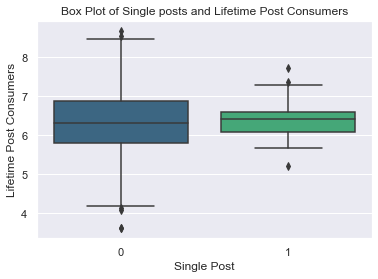

In [34]:
plt.title('Box Plot of Single posts and Lifetime Post Consumers')
sns.boxplot(x='Single Post',y='Lifetime Post Consumers',data=df,palette='viridis');

The idea behind single post was to see if there was a difference in lifetime post consumers depending on if there was only one post made a day compared to when there are multiple. It seems to suggest a slight increase on average but not by a large margin.

### Correlation Matrix

A correlation matrix can tell if any of the variables are strongly correlated and should be of concern.

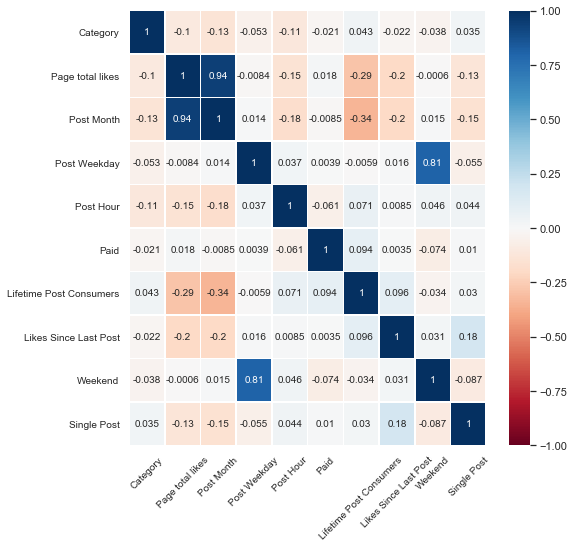

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1) 
ax = sns.heatmap(df.corr(), center=0, linewidths=0.5, 
                 cmap="RdBu", vmin=-1, vmax=1, annot=True, ax=ax, annot_kws={"size": 10})

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=10)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=10);

Page total likes and Post Month are highly correlated which is because the number of total page likes increases over the year. I will remove the page total likes from the inputs as I have my concern over its usefulness anyway.

### Create Dummy Values

In [36]:
#Dummy values

#Month
df = pd.concat([df, pd.get_dummies(df['Post Month'],prefix='m')], axis=1)

#weekday
df = pd.concat([df, pd.get_dummies(df['Post Weekday'],prefix='w')], axis=1)

#hour
df = pd.concat([df, pd.get_dummies(df['Post Hour'],prefix='hr')], axis=1)

#Type
df = pd.concat([df, pd.get_dummies(df['Type'],prefix='Type')], axis=1)

#Category
df = pd.concat([df, pd.get_dummies(df['Category'],prefix='Cat')], axis=1)

In [37]:
#Target and columns to select

target = df['Lifetime Post Consumers']

cols = ['Paid', 'Likes Since Last Post','Weekend', 'Single Post', 'm_1', 'm_2', 'm_3',
       'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12',
       'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'w_7', 'hr_1', 'hr_2',
       'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10',
       'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_22', 'hr_23', 'Type_Link', 'Type_Photo',
       'Type_Status', 'Type_Video', 'Cat_1', 'Cat_2', 'Cat_3']

X_train, X_test, y_train, y_test = train_test_split(df[cols], target, test_size=0.2, random_state=123)

#### Testing models

3 models will be tested. A linear regression, and 2 forms of linear regression with regularisation (Lasso and Ridge)

#### 1. Linear Regression

In [38]:
lin_reg = LinearRegression()

#Repeated cross validation on training set
cv= RepeatedKFold(n_splits=10, n_repeats=5, random_state = 123)
scores = cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
lin_mse = scores.mean()*-1

#Fit Linear Regression to training set and predict on test set
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

#Calculate MSE on test set
lin_mse_test = mean_squared_error(y_test, y_pred_lin)

#### 2. Ridge Regression (L2 Regularisation)

In [39]:
# define models and parameters
model = Ridge()

#setting values of alpha to tune
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid = dict(alpha=alpha)

#Repeated cross validation and alpha tuning on training set
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state = 1234)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error',error_score=0,verbose=0)
grid_result_ridge = grid_search.fit(X_train, y_train)

#Fitting Ridge regression on the training set with the best alpha
ridge_params = grid_result_ridge.best_params_
ridge_reg = Ridge(**ridge_params)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

#Calculate MSE on test set
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge)


#### 3. Lasso Regression (L1 Regularisation)

In [40]:
# define models and parameters
model = Lasso()

#setting values of alpha to tune
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid = dict(alpha=alpha)

#Repeated cross validation and alpha tuning on training set
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state = 123)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error',error_score=0,verbose=0)
grid_result_lasso = grid_search.fit(X_train, y_train)

#Fitting Lasso regression on the training set with the best alpha
lasso_params = grid_result_lasso.best_params_
lasso_reg = Lasso(**lasso_params)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)

#Calculate MSE on test set
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso)

### Results

In [41]:
data = {'Linear Regression': ['-', round(lin_mse,3), round(lin_mse_test,3)],
        'Ridge Regression':[ridge_params, round(-1*grid_result_ridge.best_score_,3), round(ridge_mse_test,3)],
       'Lasso Regression': [lasso_params, round(-1*grid_result_lasso.best_score_,3), round(lasso_mse_test,3)]}
pd.DataFrame(data, index=['Alpha', 'CV', 'Validation'])

,Linear Regression,Ridge Regression,Lasso Regression
Alpha,-,{'alpha': 1},{'alpha': 0.001}
CV,0.433,0.43,0.423
Validation,0.464,0.453,0.455


All 3 models perform similar to one another, with Lasso performing the best over the cross validation and Ridge slightly better than Lasso on the validation. The CV values are lower than the validation set which indicates some overfitting onto the training data, although the validation is still close to the CV values.

In [42]:
coef_df = pd.DataFrame({'cols':cols, 'coef':lasso_reg.coef_})
print("Lasso picked " + str(sum(coef_df['coef'] != 0)) + " features and eliminated " +  \
      str(sum(coef_df['coef'] == 0)) + " features")
coef_df

Lasso picked 40 features and eliminated 12 features


,cols,coef
0,Paid,0.144097
1,Likes Since Last Post,0.000127
2,Weekend,-0.000000
3,Single Post,-0.000000
4,m_1,0.485374
5,m_2,0.780383
6,m_3,0.000000
7,m_4,0.206051
8,m_5,0.078289
9,m_6,0.222151


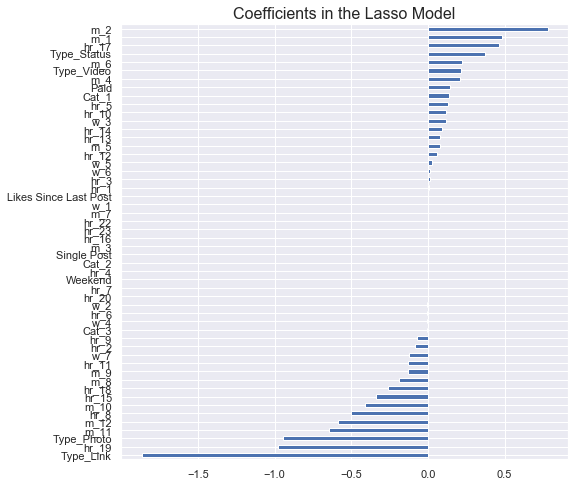

In [43]:
# Plot important coefficients
coefs = pd.Series(lasso_reg.coef_, index = X_train.columns)

plt.subplots(figsize=(8,8))
imp_coefs = coefs.sort_values()
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model", fontsize=16)
plt.show()

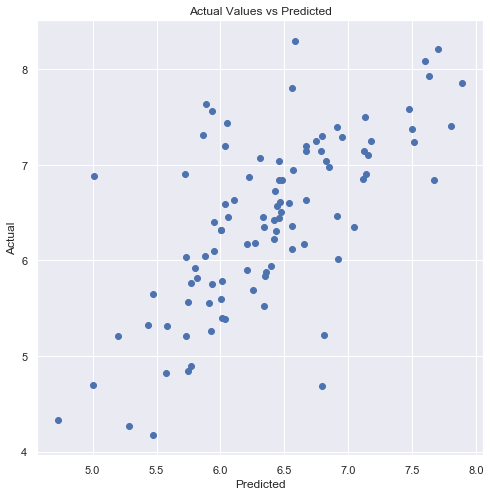

In [44]:
plt.subplots(figsize=(8,8))
plt.title('Actual Values vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.scatter(x = y_pred_lasso, y = y_test);

In [45]:
print('R2 score: ', round(r2_score(y_test, y_pred_lasso),2))

R2 score:  0.45


Whilst obviously a value closer to 1 would be desired, for the small size of data and as a baseline model an R2 score of 0.45 feels acceptable.

More feature engineering and an increase in data size would almost definitely improve the score. However it may be that the target variable has non linear relationships with some of the features and in fact other algorithms would perform better. This would be something to test with more time.

#### Residual Plot

Residual = Observed value - Predicted value

An assumption of linear regression is that the error terms are normally distributed and show Homoscedasticity.

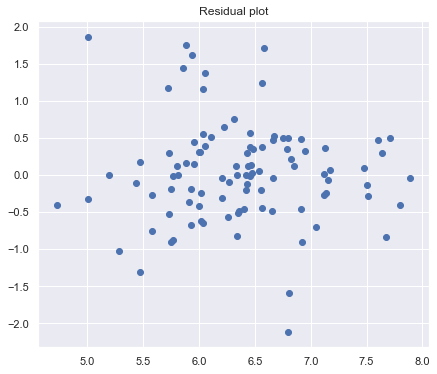

In [46]:
#Residual dataframe
res = pd.DataFrame({'test':(y_test), 'pred':(y_pred_lasso), })
res['res'] = res['test'] - res['pred']

plt.subplots(figsize=(7,6))
plt.title('Residual plot')

plt.scatter(x=res['pred'], y=res['res']);

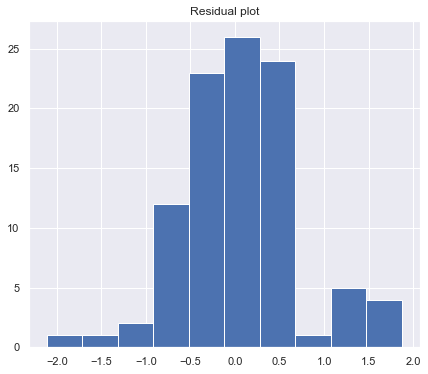

In [47]:
plt.subplots(figsize=(7,6))
plt.title('Residual plot')

plt.hist(res['res']);

From these graphs the error terms do indeed show homoscedasticity in the first plot and what looks close to a normal distribution centred around mean 0 in the second plot. This is a good sign that the model built is following the assumptions required for linear regression.

### Next Steps

1. More feature engineering - very little feature engineering was done for this model. Looking back over weeks / months and trying to use some of this previous data could provide greater accuracy. There were 2 problems with doing that in this analysis and model building, one was not knowing what weekday was being referred to in the month (due to no date information) and the second was looking back over a month would have involved removing 1 month's data to be able to use it. This would have reduced a small data set further and didn't seem beneficial for this exercise. I would want to look into some of the posts that had the highest error between actual and predicted lifetime post consumers and see if they gave any indication as to why the model couldn't pick that up from the data provided. Hopefully it would provided new ideas for features to engineer.


2. Test other models - Only linear regression has been touched upon so far to build a baseline model. Other models would also need to be tested as they might be able to uncover patterns not picked up in the linear models and produce better predictions. Additionally an ensemble of models could be used to try and achieve greater accuracy. However there comes a trade off in these situations between how complex to build the model and the way it will be used.


3. Productionalise the model - If the predictions generated by the model were needed often (say to predict the imapct of posting at a certain time or on a certain day in the week) an API could be created that would allow the trained model to be used to provide predictions if a user called the API (for example through a GUI). A package such as flask could be used to create the API.